In [1]:
import seaborn as sns
import metapack as mp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display 


import utm
from pyproj import CRS
from geoid.censusnames import stusab
import libgeohash as gh
import rowgenerators as rg
from shapely.geometry import Polygon
import geopandas as gpd
from tqdm.notebook import tqdm
tqdm.pandas()

%matplotlib inline
sns.set_context('notebook')
mp.jupyter.init()

epsg = 2163 # US Equal Area projection

# From https://gis.stackexchange.com/a/269552
def convert_wgs_to_utm(lat, lon):
    import math 
    import utm
    utm_band = str((math.floor((lon + 180) / 6 ) % 60) + 1)
    if len(utm_band) == 1:
        utm_band = '0'+utm_band
    if lat >= 0:
        epsg_code = '326' + utm_band
    else:
        epsg_code = '327' + utm_band
    return epsg_code #,  CRS.from_epsg(epsg_code), utm.from_latlon(lat, lon)

def geohash_to_polygons(ghashes):
    """
    Converts a list of geohashes to a shapely polygon.
    """
    polygons = []
    for ghash in ghashes:
        # bbox returns a tuple of lat, lon pairs which essentially is (y, x) in cartesian plane. 
        # Converting it into (x, y) before passing to shapely. 
        bounds = [ele[::-1] for ele in gh.bbox(ghash, coordinates = True)]
        polygons.append(Polygon(bounds)) 

    return polygons

from demosearch import * 
cache_dir = '/Volumes/SSD_Extern/radius'
cache = FileCache(cache_dir)
cp = CensusProcessor(cache, 2019, progress_bar=True)
tp = TractProcessor(cache)

In [2]:
#pkg = mp.jupyter.open_package()
pkg = mp.jupyter.open_source_package()


# Geohashes and Tracts for Continential US
`civicknowledge.com-geohash-us-1.1.1` Last Update: 2021-01-29T18:38:16

_Linkes between geohashes and tracts for the continential us_


This data provides tracts for the continential US, linked to 
4-character geohashes, and a dataset that provides the 
percentage of overlap between them. 

## Caveats

The `gh_in_tract_prop` and  `tract_in_gh_prop` columns in the overlay
file are intended to be used for crosswalks but they don't seem 
to be correct yet.


 

## Contacts

* **Wrangler** [Eric Busboom](mailto:eric@civicknowledge.com), [Civic Knowledge](http://civicknowledge.com)

## Resources

* ** [us_tracts](notebooks/Extract.ipynb#tracts)**. Census tracts in the continential US, with geohash and UTM zone
* ** [us_geohashes](notebooks/Extract.ipynb#ghdf)**. Four digit geohashes in  the continential US, with UTM zone
* ** [tract_geohash overlay](notebooks/Extract.ipynb#ovl)**. Links between geohashes and tracts and the portion of their overlap.

## References
<ul><li> <strong>us_states</string>, <em>censusgeo://2019/5/US/state</em>. US States geographic boundaries</li><li> <strong>us_tracts_template</string>, <em>censusgeo://2019/5/{st}/tract</em>. Template URL for US tracts</li><ul>

<AxesSubplot:>

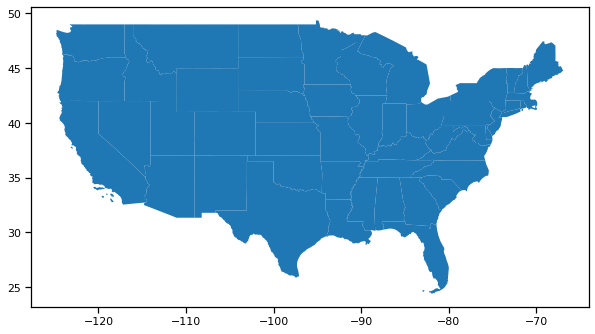

In [3]:
states = pkg.reference('us_states').geoframe() # US Equal area projection
continental_states = states[~states.stusps.isin(['HI','AK','PR','VI','MP','GU','AS'])]
continential_fp =   continental_states.statefp.unique()
continental_states.plot(figsize=(10,10))

In [4]:
%%time
url_t = pkg.reference('us_tracts_template').url
frames = [rg.geoframe(url_t.format(st=st)) for st in tqdm(stusab.values())]
tracts = pd.concat(frames)

# Mark the tracts in the continential US
tracts['continential'] = tracts.statefp.isin(continential_fp)
tracts['tract_id'] = tracts.reset_index().index

# Need to convert to each UTM zone to get accurate area
# computation. 
#tracts = tracts.sort_values('geoid').reset_index()
#frames = [ g.to_crs(int(idx)).area for idx, g in tracts.groupby('utm_epsg')]
#t = pd.concat(frames).to_frame('utm_area')
#tracts = tracts.join(t)

tracts['geohash'] = tracts[['intptlat', 'intptlon']].astype(float).apply(lambda r: gh.encode(r.intptlat, r.intptlon), axis=1)

tracts['gh4'] = tracts.geohash.str.slice(0,4)

tracts = tracts[tracts.continential]
tracts = tracts[['geoid', 'tract_id', 'geohash', 'statefp', 'intptlat', 'intptlon', 'geometry','aland','awater','gh4']]

  0%|          | 0/52 [00:00<?, ?it/s]

CPU times: user 20.1 s, sys: 790 ms, total: 20.8 s
Wall time: 20.9 s


In [5]:
# The error in the compute area vs that provided by the source data is less than 
# 0.2% So, we don't actualy need to to it, but it is 
# nice to see that it works properly. 
#(((tracts.aland + tracts.awater) - tracts.utm_area) / (tracts.aland + tracts.awater) ).hist()

In [6]:
ush = gh.polygon_to_geohash(continental_states.unary_union, 4)
len(ush)

14189

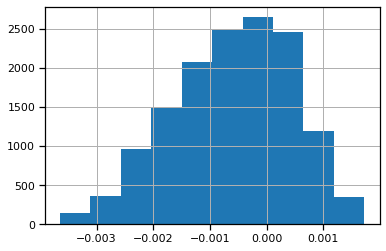

In [7]:
ghdf = gpd.GeoDataFrame({'geohash':ush}, geometry=geohash_to_polygons(ush), crs=4326)
dims = pd.DataFrame(ghdf.geohash.apply(lambda g: gh.dimensions(g, True)).to_list(),  columns = ['dx','dy'])
ghdf = pd.concat([ghdf, dims], axis=1)

# Compute the area in square meters, but we convert each UTM group to the 
# appropriate UTM zone first
ghdf['utm_epsg'] = ghdf.geohash.apply(lambda v: convert_wgs_to_utm(*gh.decode(v)))
ghdf['utm_epsg'] = ghdf['utm_epsg'].astype(int)

frames = [ g.to_crs(int(idx)).area for idx, g in ghdf.groupby('utm_epsg')]
t = pd.concat(frames).to_frame('utm_area')
ghdf = ghdf.join(t)

ghdf['gh_area'] = ghdf.dx * ghdf.dy


# The differences between the UTM are computation and that from the geohash 
# are also pretty small, also mostly less than 0.2%
( (ghdf.utm_area - ghdf.gh_area) / ghdf.utm_area).hist();

In [8]:
tracts = tracts.merge(ghdf[['geohash', 'utm_epsg']].rename(columns={'geohash':'gh4'}), on='gh4', how='left')

<AxesSubplot:>

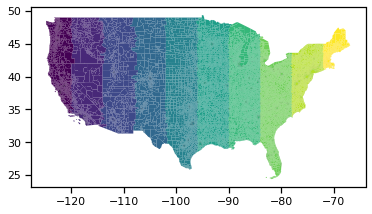

In [9]:
tracts.plot(column='utm_epsg')

In [10]:
tracts.head()

,geoid,tract_id,geohash,statefp,intptlat,intptlon,geometry,aland,awater,gh4,utm_epsg
0,14000US01055010700,0,dn4cv6dpesn6,01,+34.0726595,-085.8991944,"POLYGON ((-85.98699 34.04413, -85.98606 34.045...",87404337,2927199,dn4c,32616
1,14000US01055001300,1,dn4c7qfqppgz,01,+34.0078782,-085.9865947,"POLYGON ((-86.00068 34.00537, -86.00023 34.006...",5083957,836213,dn4c,32616
2,14000US01055000900,2,dn4c6j9d6k5c,01,+34.0003469,-086.0427603,"POLYGON ((-86.07079 34.00011, -86.07076 34.000...",11932347,740907,dn4c,32616
3,14000US01055001700,3,dn4ck47f94bn,01,+33.9825311,-085.9518384,"POLYGON ((-85.96885 33.98825, -85.96884 33.988...",9118882,0,dn4c,32616
4,14000US01055010501,4,dn4bf75jt3xx,01,+33.8992688,-086.0295803,"POLYGON ((-86.07352 33.90549, -86.07337 33.906...",50209675,7198559,dn4b,32616


In [11]:
ghdf.head()

,geohash,geometry,dx,dy,utm_epsg,utm_area,gh_area
0,9wf7,"POLYGON ((-109.33594 38.49609, -109.33594 38.6...",30595.374471,19546.010197,32612,5.976261e+08,5.980175e+08
1,9qg2,"POLYGON ((-119.17969 37.96875, -119.17969 38.1...",30818.036328,19546.010197,32611,6.019945e+08,6.023697e+08
2,dqcm,"POLYGON ((-76.99219 38.84766, -76.99219 39.023...",30445.492194,19546.010197,32618,5.947239e+08,5.950879e+08
3,dnjn,"POLYGON ((-82.96875 34.80469, -82.96875 34.980...",32098.539857,19546.010197,32617,6.265837e+08,6.273984e+08
4,dne8,"POLYGON ((-85.07812 36.56250, -85.07812 36.738...",31398.987723,19546.010197,32616,6.132489e+08,6.137249e+08


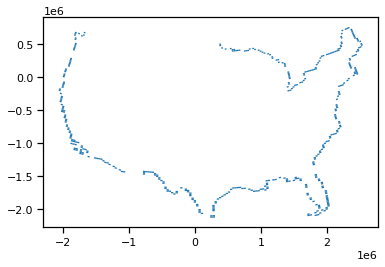

In [12]:

t = ghdf.copy().to_crs(epsg)
t['geometry'] = t.geometry.centroid
tracts2163 = tracts.to_crs(epsg)
t = gpd.sjoin(t, tracts2163)

# Geohashes where the centroid is not in any tract; arround the edges, as you'd expect
niat = ghdf[~ghdf.geohash.isin(t.geohash_left)].to_crs(epsg)
niat.plot()

# find a link from geohash to tract by ovelap, rather than centroid
nait = gpd.overlay(niat, tracts2163)
nait['a'] = nait.area
nait = nait.sort_values('a', ascending=False).drop_duplicates(subset=['geohash_1'])

# Combine them together. 
geo_to_tract = pd.concat([nait[['geohash_1','geoid']].rename(columns={'geohash_1':'geohash'}), 
                          t[['geohash_left', 'geoid']].rename(columns={'geohash_left':'geohash'})])

In [13]:
tracts['tract_id'] = tracts.reset_index().index
tg = tracts[['tract_id','geometry', 'utm_epsg']].groupby('utm_epsg')
gg = ghdf[['geohash', 'utm_epsg','geometry']].groupby('utm_epsg')

frames = []

for utm_epsg in tqdm(set(list(tg.indices.keys()) + list(gg.indices.keys()))):
    try:
        t = tg.get_group(utm_epsg).to_crs(int(utm_epsg))
    except KeyError as e:
        print("ERROR. No tract for ", utm_epsg, e)
        continue
        
    try:
        g = gg.get_group(utm_epsg).to_crs(int(utm_epsg))
    except KeyError as e:
        print("ERROR. No geohashes for ", utm_epsg, e)
        continue

    ovl = gpd.overlay(g, t)
    
    ovl[['ovl_area']] = ovl.area
   
    frames.append(ovl)

  0%|          | 0/10 [00:00<?, ?it/s]

In [14]:
ovl

,geohash,utm_epsg_1,tract_id,utm_epsg_2,geometry,ovl_area
0,f2rt,32619,29203,32619,"POLYGON ((560259.648 5237161.183, 560197.934 5...",9.518930e+06
1,f2rs,32619,29203,32619,"POLYGON ((560355.333 5227784.938, 560259.648 5...",1.622870e+07
2,f2rk,32619,29203,32619,"POLYGON ((553671.363 5237108.708, 560259.648 5...",4.199066e+07
3,f2rm,32619,29203,32619,"POLYGON ((560197.934 5243191.520, 560259.648 5...",7.779496e+07
4,f2rt,32619,29268,32619,"POLYGON ((566907.437 5237244.109, 561911.189 5...",1.334403e+07
...,...,...,...,...,...,...
3693,drmw,32619,32072,32619,"POLYGON ((354849.690 4643039.678, 354884.681 4...",1.710646e+07
3694,drym,32619,29035,32619,"POLYGON ((447170.438 4937221.966, 447301.895 4...",7.139794e+06
3695,drym,32619,29254,32619,"POLYGON ((437065.661 4936333.988, 437074.625 4...",7.302246e+07
3696,drym,32619,29256,32619,"POLYGON ((442778.312 4928494.595, 442899.692 4...",2.437733e+07


In [15]:

ovl = pd.concat(frames).drop(columns=['utm_epsg_1','utm_epsg_2','geometry'])
print(len(ovl), ovl.geohash.nunique(), ovl.tract_id.nunique(), len(tracts))
ovl = ovl.merge(tracts[['geoid','tract_id','aland','awater']]).merge(ghdf[['geohash','utm_area']]).rename(columns={'utm_area':'gh_area'})
ovl['tract_area'] = ovl.aland + ovl.awater
ovl['gh_in_tract_prop'] = ovl.ovl_area/ovl.tract_area
ovl['tract_in_gh_prop'] = ovl.ovl_area/ovl.gh_area

ovl['ovl_area'] = ovl.ovl_area.astype(int)
ovl['gh_area'] = ovl.gh_area.astype(int)

ovl = ovl[['geohash', 'tract_id',  'geoid', 'aland', 'awater', 'tract_area', 'gh_area', 'ovl_area', 'gh_in_tract_prop', 'tract_in_gh_prop']]

ovl.head()

131425 14144 72537 72538


,geohash,tract_id,geoid,aland,awater,tract_area,gh_area,ovl_area,gh_in_tract_prop,tract_in_gh_prop
0,9rfe,54799,14000US41013950400,5532113626,15998089,5548111715,549127155,549127155,0.098976,1.000000
1,9rf7,54799,14000US41013950400,5532113626,15998089,5548111715,548959536,443843414,0.079999,0.808518
2,9rf7,54800,14000US41013950100,1334552212,4329371,1338881583,548959536,105116121,0.078510,0.191482
3,9rcg,54799,14000US41013950400,5532113626,15998089,5548111715,548688296,15124501,0.002726,0.027565
4,9rcg,54798,14000US41013950200,432242968,152052,432395020,548688296,802031,0.001855,0.001462


<AxesSubplot:>

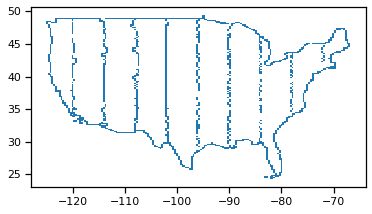

In [16]:
# There are a lot of partial geohashes at the boundaries of the US and the UTM zones. 
# The sum should be 1 everywhere. 
t = ovl.groupby('geohash').sum().tract_in_gh_prop 
ghdf[ghdf.geohash.isin(t[t< .95].index)].plot()